### Проект:
Представленны небольшие выборки данных по использованию тарифов ultra и smart сети «Мегалайн».
     - Таблица users (информация о пользователях);
     - Таблица calls (информация о звонках);
     - Таблица messages (информация о сообщениях);
     - Таблица internet (информация об интернет-сессиях);
     - Таблица tariffs (информация о тарифах).

### Цель:
Необходимо дать анализ тарифов smart и ultra, сделать вывод какой из них лучше, какой нуждается в доразвитии.

### План работы:
1. Подгрузить все библиотеки, и откыть исходные данные
2. Подготовить данные для анализа, изменить тип данных при необходимости. Убрать или заполнить недостающие данные. Посчитать для каждого пользователя:
    количество сделанных звонков и израсходованных минут разговора по месяцам;
    количество отправленных сообщений по месяцам;
    объем израсходованного интернет-трафика по месяцам;
    помесячную выручку с каждого пользователя.
3. Провести анализ данных, построить необходимые распределения, описать их статитистические параметры.
4. Выдвинуть гипотезы, опровергнуть или принять их.
5. Сделать общий вывод.

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math 
from scipy import stats as st
import seaborn as sns

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet=pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### Шаг 2. Подготовьте данные

#### Шаг 2.1. Приведите данные к нужным типам

In [4]:
calls.info()
calls.head(5) #надо поменять на тип date столбец call_date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')

In [6]:
internet.info()
internet.head(5) #на поменять на тип date столбец session_date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [7]:
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y-%m-%d')

In [8]:
messages.info()
messages.head(5) #на поменять на тип date столбец message_date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y-%m-%d')

In [10]:
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
users.info()
users.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [13]:
users = users[['user_id','city','tariff']]
users.head(5) # оставляем только индекс пользователя, город и название тарифа, имена пользователей нам не понадобятся

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


##### Промежуточный вывод: Шаг 2.1. Приведите данные к нужным типам

1. Подгружаем предоставленные таблицы и смотрим какими типами данных они заполнены через метод .info() 

**Проверяем тип данны**

1. Видно, что в каждой таблице столбцы с датами имеют тип **object**, который следует поменять на **datetime**. Делаем это через **pd.to_datetime** в каждой таблице, для нужных столбцов.
1. Остальные типы данных нас устраивают, займемся поиском и исправлением ошибок.

---
## Комментарий от наставника

Первый взгляд на данные выполнен. Исправлен формат у даты в данных. А что по поводу звонков с длительностью в 0 минут?

---

#### Шаг 2.2. Найдите и исправьте ошибки в данных

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bbd858b70>]],
      dtype=object)

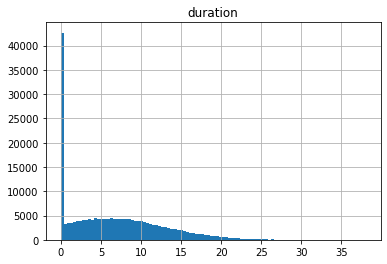

In [14]:
calls.hist(bins = 100, column = 'duration') # строим гистограмму по начальному графику

In [15]:
calls['duration'].value_counts() # видно что 0 значений слишком много

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64

In [16]:
calls.loc[(calls['duration'] != 0) & (calls['duration'] < 1 ),'duration'] = 1 # по условию тарифа округляем 0<x<1 до 1 

In [17]:
calls['duration'].replace(0, np.nan, inplace=True) #заменяем 0 на nan
calls = calls.dropna() #дропаем nan

In [18]:
calls['duration'] = calls['duration'].apply(np.ceil) #округляем до целых (условие тарифа)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bbd677f28>]],
      dtype=object)

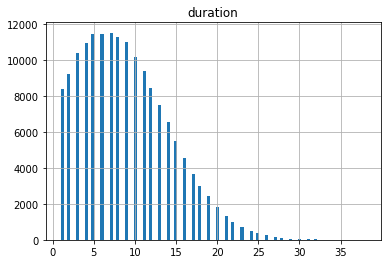

In [19]:
calls.hist(bins = 100, column = 'duration' ) # нулевые вылеты теперь отсутствуют

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bbc644978>]],
      dtype=object)

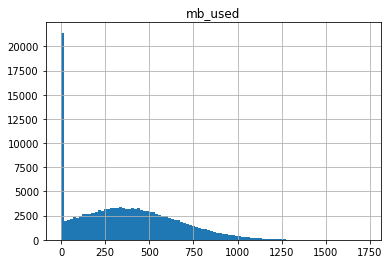

In [20]:
internet.hist(bins=100, column = 'mb_used') # строим гистограмму по данным использованных мб.

In [21]:
internet['mb_used'].value_counts() # опять, слишком много 0

0.00      19598
197.56        9
447.30        9
335.91        9
108.95        8
          ...  
72.49         1
846.22        1
429.17        1
899.03        1
483.87        1
Name: mb_used, Length: 70003, dtype: int64

In [22]:
internet.loc[(internet['mb_used'] != 0) & (internet['mb_used'] < 1 ),'mb_used'] = 1 # по условию тарифа округляем 0<x<1 до 1 

In [23]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil) # округляем до целых использованные мб

In [24]:
internet['mb_used'].replace(0, np.nan, inplace=True)
internet = internet.dropna() # дропаем nan

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bbe24e208>]],
      dtype=object)

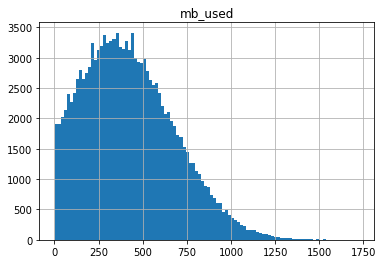

In [25]:
internet.hist(bins=100, column = 'mb_used') # снова строим гистограмму, вылеты в 0 теперь отсутсвтуют

##### Промежуточный вывод:Шаг 2.2. Найдите и исправьте ошибки в данных

1. Обратим внимание, что «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Соответсвенно проверим как распределены данные в таблицах **calls** и **internet**.
1. Для каждой из таблиц строим гистограмму методом **.hist()** и считаем повторяющиеся значения по интересующему столбцу методом **.value_counts()**.
1. Видим, что гистограммы выглядят ожидаемо. Не удивительно что в 0 имеются вылеты, ведь для **calls**  нулевых значений **39613**, для internet - **19598**. Вывод: много нулевых значений, происхождение которых установить затруднительно. Попытаемся не избавляться от них, а превратить в **Nan** попутно присвая значение **1** данным находящимся в промежутке от **0 до 1**.
1. Для обеих таблиц результаты улучшились. Видно, что для **calls**, гистограмма имеет логнормальное распределение, с ярким вылетом в значении 1 (но намного меньшим, чем было с вылетом 0). Для **internet** ситуация еще лучше, гистограмма имеет вид логнормального распределения, без всяких вылетов.
1. Далее для каждого пользователя займемся рассчетом: 
    1. количества сделанных звонков и израсходованных минут разговора по месяцам;  
    1. отправленных сообщений по месяцам; 
    1. объема израсходованного интернет-трафика по месяцам;
    1. помесячной выручки с каждого пользователя.
1. Также для каждой таблицы посчитали колличество nan, видно что их много, но после группировки они должны будут исчезнуть.
1. Округлим значения вврех у столбцов **duration** и **mb_used** в таблицах **call** и **internet** соответсвенно методом ceil.
1. Удалим пустые строки из таблиц методом dropna

#### Шаг 2.3.1 Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам

In [26]:
calls['to_month'] = calls['call_date'].dt.month

In [27]:
calls_id_count = calls.pivot_table(
     index = ['user_id','to_month'],  values =  ['id','duration'], aggfunc = ({'id': 'count', 'duration': 'sum'}))

In [28]:
calls_id_count.columns = ['calls_duration','calls_count']
calls_id_count.head()

calls_duration  calls_count
user_id to_month                             
1000    5                  159.0           17
        6                  172.0           28
        7                  340.0           41
        8                  408.0           42
        9                  466.0           46

##### Промежуточный вывод:Шаг 2.3.1 Расчет количества сделаных звонков и израсходованных минут разговора по месяцам
1. Добавим новый столбец **to_month**(округлит все значения до года и месяца) к таблице **call** методом **.dt.to_period**
1. Применим **pivot_table** для группировки по **id_user** и месяцу. В качестве значений передадим **id** и **duration**, для первого столбца применим метод **count**, для второго **sum**.
1. Переименуем столбыв в **calls_duration, calls_count** соответсвенно и выведем новый датафрейм **calls_id_count**. Теперь для каждого пользовотелся видно, сколько он проговорил в месяц.

#### Шаг 2.3.2 Посчитаем для каждого пользователя количество отправленных сообщений по месяцам;

In [29]:
messages['to_month'] = messages['message_date'].dt.month

In [30]:
messages_id_count = messages.pivot_table(
     index = ['user_id','to_month'],  values =  'id', aggfunc = 'count')

In [31]:
messages_id_count.columns = ['messages_count']
messages_id_count.head()

messages_count
user_id to_month                
1000    5                     22
        6                     60
        7                     75
        8                     81
        9                     57

##### Промежуточный вывод:Шаг 2.3.2 Расчет количества отправленных сообщений по месяцам
Повторим шаги пункта 2.2.3. получаем новый датафрейм **messages_id_count**, где для каждого пользовотелся видно, сколько сообщений в месяц он отправил.

#### Шаг 2.3.3 Посчитаем для каждого пользователя объем израсходованного интернет-трафика по месяцам;

In [32]:
internet['to_month'] = internet['session_date'].dt.month

In [33]:
internet_id_count = internet.pivot_table(
     index = ['user_id','to_month'],  values =  'mb_used', aggfunc = 'sum')

In [34]:
internet_id_count.head()

mb_used
user_id to_month         
1000    5          2256.0
        6         23257.0
        7         14016.0
        8         14070.0
        9         14581.0

##### Промежуточный вывод: Шаг 2.3.3 Расчет объема израсходованного интернет-трафика по месяцам.
Повторим шаги пункта 2.2.3. получаем новый датафрейм **internet_id_count**, где для каждого пользовотелся видно, сколько мб интернета в месяц он отправил.

#### Шаг 2.3.4 Посчитаем помесячную выручку с каждого пользователя;

In [35]:
total_id_count = pd.merge(calls_id_count, messages_id_count, how= 'outer', left_index=True, right_index=True)
total_id_count = pd.merge(total_id_count, internet_id_count, how= 'outer', left_index=True, right_index=True)

In [36]:
total = pd.merge(total_id_count, users, on = 'user_id',right_index=True)
total.head()

calls_duration  calls_count  messages_count  mb_used  \
user_id to_month                                                         
1000    5                  159.0         17.0            22.0   2256.0   
        6                  172.0         28.0            60.0  23257.0   
        7                  340.0         41.0            75.0  14016.0   
        8                  408.0         42.0            81.0  14070.0   
        9                  466.0         46.0            57.0  14581.0   

                       city tariff  
user_id to_month                    
1000    5         Краснодар  ultra  
        6         Краснодар  ultra  
        7         Краснодар  ultra  
        8         Краснодар  ultra  
        9         Краснодар  ultra

---
## Комментарий от наставника

Из-за того, что нет округления значений, получается нецелая выручка с клиентов.

---

In [37]:
tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [38]:
def revenue(row):
    calls_duration =row['calls_duration']
    messages_count = row['messages_count']
    mb_used = row['mb_used']
    tariff = row['tariff']
    if 'ultra' in tariff:
        cost = tariffs.loc[1,'rub_monthly_fee']
        if calls_duration > tariffs.loc[1,'minutes_included']:
            cost += (calls_duration - tariffs.loc[1,'minutes_included'])*tariffs.loc[1,'rub_per_minute']
            return cost
        if messages_count > tariffs.loc[1,'messages_included']:
            cost += (messages_count- tariffs.loc[1,'messages_included'])*tariffs.loc[1,'rub_per_message']
            return cost
        if mb_used > tariffs.loc[1,'mg_per_month_included']:
            cost += (math.ceil((mb_used - tariffs.loc[1,'mg_per_month_included'])//1024))*tariffs.loc[1,'rub_per_gb']
            return cost
        return cost
    if 'smart' in tariff:
        cost = tariffs.loc[0,'rub_monthly_fee']
        if calls_duration > tariffs.loc[0,'minutes_included']:
            cost += (calls_duration - tariffs.loc[0,'minutes_included'])*tariffs.loc[0,'rub_per_minute']
            return cost
        if messages_count > tariffs.loc[0,'messages_included']:
            cost += (messages_count- tariffs.loc[0,'messages_included'])*tariffs.loc[0,'rub_per_message']
            return cost
        if mb_used > tariffs.loc[0,'mg_per_month_included']:
            cost += (math.ceil((mb_used - tariffs.loc[0,'mg_per_month_included'])//1024))*tariffs.loc[0,'rub_per_gb']
            return cost
        return cost

In [39]:
total['revenue'] = total.apply(revenue, axis=1)
total.head()

calls_duration  calls_count  messages_count  mb_used  \
user_id to_month                                                         
1000    5                  159.0         17.0            22.0   2256.0   
        6                  172.0         28.0            60.0  23257.0   
        7                  340.0         41.0            75.0  14016.0   
        8                  408.0         42.0            81.0  14070.0   
        9                  466.0         46.0            57.0  14581.0   

                       city tariff  revenue  
user_id to_month                             
1000    5         Краснодар  ultra   1950.0  
        6         Краснодар  ultra   1950.0  
        7         Краснодар  ultra   1950.0  
        8         Краснодар  ultra   1950.0  
        9         Краснодар  ultra   1950.0

##### Промежуточный вывод: Шаг 2.3.4 Расчет выручки с каждого клиента.
1. Соединяем таблицы **calls_id_count**, **messages_id_count** и **internet_id_count** в единую таблицу **total_id_count** с помощью pd.merge. Получаем единую таблицу со всеми сделанными звонками, потраченым трафиком и отправленными сообщениями для пользователя по месяцам.
1. Добавим к полученной таблице город и тарифный план из **users** и получим финальную таблицу **total**.
1. Напишем функцию **revenue**, которая будет брать столбцы **calls_duration**, **messages_count** и **mb_used**,где в зависимости от условий тарифа (которые берутся из таблицы **tariffs**) будет считаться  выручка с клиента.
1. Применим функцию к дф **total**. Получаем новый столбец **revenue**.

#### Шаг 3.  Анализ данных
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

#### Анализируем тариф ultra

In [40]:
total = total.dropna()

In [41]:
total.isna().sum()

calls_duration    0
calls_count       0
messages_count    0
mb_used           0
city              0
tariff            0
revenue           0
dtype: int64

In [42]:
total.query('"ultra" in tariff').describe() # смотрим статистику по тарифу ultra

,calls_duration,calls_count,messages_count,mb_used,revenue
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,559.692513,63.005348,61.356952,19628.148396,2032.018717
std,310.249745,34.744236,44.516827,9634.151356,297.952971
min,1.000000,1.000000,1.000000,440.000000,1950.000000
25%,333.750000,37.000000,25.000000,11917.000000,1950.000000
50%,539.500000,61.000000,52.500000,19458.000000,1950.000000
75%,761.250000,85.000000,88.000000,26869.500000,1950.000000
max,1673.000000,190.000000,224.000000,49789.000000,4650.000000


In [43]:
total.query('"ultra" in tariff').var().astype(np.int64) # + смотрим дисперсию

calls_duration       96254
calls_count           1207
messages_count        1981
mb_used           92816872
revenue              88775
dtype: int64

#### Анализируем тариф смарт

In [44]:
total.query('"smart" in tariff').describe()

,calls_duration,calls_count,messages_count,mb_used,revenue
count,1912.000000,1912.000000,1912.000000,1912.000000,1912.000000
mean,421.673117,47.340481,38.787657,16276.163180,884.073222
std,187.164891,20.634688,26.815666,5789.603131,486.692186
min,2.000000,1.000000,1.000000,202.000000,550.000000
25%,288.750000,32.000000,17.000000,12653.750000,550.000000
50%,427.000000,48.000000,34.000000,16484.500000,676.000000
75%,547.000000,62.000000,55.000000,20068.000000,1015.750000
max,1435.000000,162.000000,143.000000,38610.000000,3950.000000


In [45]:
total.query('"smart" in tariff').var().astype(np.int64)

calls_duration       35030
calls_count            425
messages_count         719
mb_used           33519504
revenue             236869
dtype: int64

#### Начинаем сравнивать распределения по типу тарифа для каждого столбца

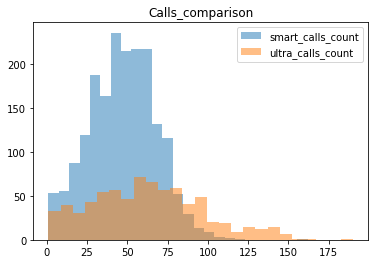

In [46]:
plt.hist(total.query('"smart" in tariff')['calls_count'], bins = 25, alpha=0.5, label='smart_calls_count')
plt.hist(total.query('"ultra" in tariff')['calls_count'], bins= 25, alpha=0.5, label='ultra_calls_count')
plt.legend(loc='upper right')
plt.title('Calls_comparison')
plt.show()

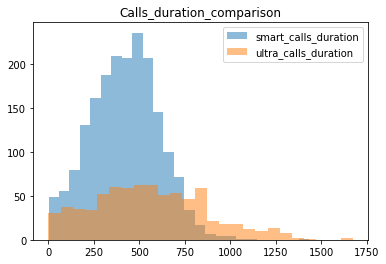

In [47]:
plt.hist(total.query('"smart" in tariff')['calls_duration'], bins = 25, alpha=0.5, label='smart_calls_duration')
plt.hist(total.query('"ultra" in tariff')['calls_duration'], bins= 25, alpha=0.5, label='ultra_calls_duration')
plt.legend(loc='upper right')
plt.title('Calls_duration_comparison')
plt.show()

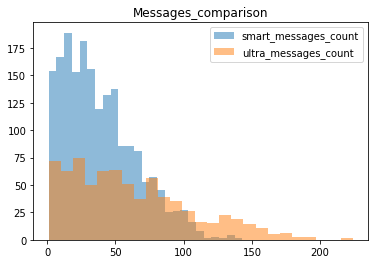

In [48]:
plt.hist(total.query('"smart" in tariff')['messages_count'], bins = 25, alpha=0.5, label='smart_messages_count')
plt.hist(total.query('"ultra" in tariff')['messages_count'], bins= 25, alpha=0.5, label='ultra_messages_count')
plt.legend(loc='upper right')
plt.title('Messages_comparison')
plt.show()

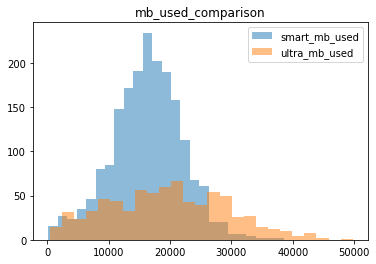

In [49]:
plt.hist(total.query('"smart" in tariff')['mb_used'],histtype = 'barstacked', bins = 25, alpha=0.5, label='smart_mb_used')
plt.hist(total.query('"ultra" in tariff')['mb_used'],histtype = 'barstacked', bins= 25, alpha=0.5, label='ultra_mb_used')
plt.legend(loc='upper right')
plt.title('mb_used_comparison')
plt.show()

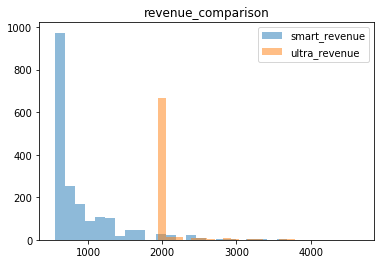

In [50]:
plt.hist(total.query('"smart" in tariff')['revenue'], bins = 25, alpha=0.5, label='smart_revenue')
plt.hist(total.query('"ultra" in tariff')['revenue'], bins= 25, alpha=0.5, label='ultra_revenue')
plt.legend(loc='upper right')
plt.title('revenue_comparison')
plt.show()

##### Промежуточный вывод:  Анализ тарифа ultra

1. Строим гистограммы по тарифу **ultra** методом hist. Видно, что данные по количеству звонков, продолжительности звонков и использовнных мб имеют нормальные расрпеделния. Данне по смс сообщениям имеют скошеное распределение (видно, что смсками пользуются не так активно)
1. Выводи статистическую информацию методом describe. Отмечаем, что средняя выручка равна 2032 р, значит есть значимая доля людей, чьи расходы выходят за рамки тарифа.

##### Промежуточный вывод:  Анализ тарифа Smart

1. Строим гистограммы по тарифу **smart** методом hist. Видно, что данные по количеству звонков, продолжительности звонков и использовнных мб имеют нормальные расрпеделния. Данне по смс сообщениям имеют скошеное распределение как и в **ultra** 
1. Выводи статистическую информацию методом describe. Отмечаем, что средняя выручка равна 882 р, что практически в полтора раза больше, чем абонентская плата.

---
## Комментарий от наставника

Все сделано верно, базовые статистические параметры получены.

---

#### Шаг 4. Проверьте гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

In [51]:
x = total.query('"smart" in tariff')['revenue']
y = total.query('"ultra" in tariff')['revenue']

In [52]:
alpha = 0.05

In [53]:
results = st.ttest_ind(
    x,y)
results

Ttest_indResult(statistic=-60.23936153479038, pvalue=0.0)

In [54]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


In [55]:
x = total.query('"smart" in tariff')['revenue'].sum()
y = total.query('"ultra" in tariff')['revenue'].sum() # смотрим какая была выручка по каждому из тарифов 
print(x,y)

1690348.0 1519950.0


In [56]:
x_mean = total.query('"smart" in tariff')['revenue'].mean()
y_mean =  total.query('"ultra" in tariff')['revenue'].mean() # смотрим среднюю выручку с человека по тарифу
print(x_mean,y_mean)

884.0732217573221 2032.01871657754


In [57]:
# доверительные интервалы не смог расчитать

---
## Комментарий от наставника

Лучше выводить средние значения дохода с каждого клиента с их доверительными интервалами.

---

##### Промежуточный вывод: Шаг 4.1 Проверка гипотезы, средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

1. Для проверки нашей гипотезы сначала надо поставить нулевую гипотезу. Нулевая гипотеза будет такая: средняя выручка **Ультра** и **Смарт** равны между собой.
1. Первым делом сделаем 2 дата фрейма в первом будет только тариф **smart** во втором **ultra**
1. Установим alpha на уровне 5%
1. Применим **st.ttest_ind**, где аргументами передадим сформированные таблицы по тарифам.
1. Проверим нулевую гипотезу. Резултат говрит, что следует отвергнуть нулевую гипотезу. И действительно нулевая гипотеза была слишком нереалистичной. Еще на этапе анализа данных было видно, что среднии выручки по тарифам отличались.
1. Раз гипотеза не сработала, то попытаемся понять, какой тариф приности больше денег. Просто вывыдем суммы выручки по каждому тарифу. Видно, что выручки практически равны. Скорее всего следует вкладывать деньги в развитие обоих тарифов.

#### Шаг 4. Проверьте гипотезы:средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

In [58]:
list1 = ['Москва']

In [59]:
total['by_locality'] = total['city'].where(total['city'].isin(list1), "Другое")

In [60]:
total.head()

calls_duration  calls_count  messages_count  mb_used  \
user_id to_month                                                         
1000    5                  159.0         17.0            22.0   2256.0   
        6                  172.0         28.0            60.0  23257.0   
        7                  340.0         41.0            75.0  14016.0   
        8                  408.0         42.0            81.0  14070.0   
        9                  466.0         46.0            57.0  14581.0   

                       city tariff  revenue by_locality  
user_id to_month                                         
1000    5         Краснодар  ultra   1950.0      Другое  
        6         Краснодар  ultra   1950.0      Другое  
        7         Краснодар  ultra   1950.0      Другое  
        8         Краснодар  ultra   1950.0      Другое  
        9         Краснодар  ultra   1950.0      Другое

In [61]:
Moscow = total.query('"Москва" in by_locality')['revenue']
Other = total.query('"Другое" in by_locality')['revenue']

In [62]:
alpha = 0.05

In [63]:
results = st.ttest_ind(
    Moscow, Other)
results

Ttest_indResult(statistic=4.415156166159305, pvalue=1.0496766137564505e-05)

In [64]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0496766137564505e-05
Отвергаем нулевую гипотезу


In [65]:
total.query('"Москва" in by_locality')['revenue'].describe()

count     491.000000
mean     1328.704684
std       703.289121
min       550.000000
25%       616.000000
50%      1150.000000
75%      1950.000000
max      3900.000000
Name: revenue, dtype: float64

In [66]:
total.query('"Другое" in by_locality')['revenue'].describe()

count    2169.000000
mean     1179.301060
std       671.023755
min       550.000000
25%       580.000000
50%       886.000000
75%      1950.000000
max      4650.000000
Name: revenue, dtype: float64

1. Для проверки гипотезы о выручке в зависимости от региона сначала надо поставить нулевую гипотезу. Нулевая гипотеза будет такая: средняя выручка м/у Москвой и другими городами одинаковы.
1. Первым делом создадим новый столбец, где разобьем данные на **Москву** и **Другое**.
1. Сделаем 2 дата фрейма в первом будет только  **Москва** во втором **Другое**
1. Установим alpha на уровне 5%
1. Применим **st.ttest_ind**, где аргументами передадим сформированные таблицы по региону интереса.
1. Проверим нулевую гипотезу. Резултат говрит, что следует отвергнуть нулевую гипотезу, следовательно выручка в Москве отличается от выручки в других регионах.
1. Сравним выручки по м/у регионами и Москвой. Выведем данные по Москве и заметим, что среднее и медиана слабо отличаются,значит с Мосвкой все относительно понятно, все тратят +- одинаково. Отдельный интерес представлют "Регионы", видно что mean > p50, из чего можно сделать вывод, что есть определенная прослойка граждан, которая тратит много денег на мобильную связь. Было бы здорово найти эту самую прослойку и акцентировать внимание маркетологов на ней.

# Общий вывод:

**Подготовка данных**

1. Данные поспупили в удовлетворительном виде, единственное потребовалось замена типа object на date для 3 таблиц
1. Также пришлось удалить 0 значения, а остальные привести к целочисленному виду путем округления вверх
1. Для каждого пользователя посчитаны: количество сделанных звонков и израсходованных минут разговора по месяцам; количество отправленных сообщений по месяцам; объем израсходованного интернет-трафика по месяцам; помесячную выручку с каждого пользователя. Создана единая таблица, по всем параметрам

**Анализ данных**
1. Видно, что ultra имеет более широкий разрос по всем параметрам. Это не удивительно, покупая тариф за 1950 клиенты в первую очередь ориентируются на свои потребности, отсюда и более активное использование телефона для разных целей
1. Как и предполагалось средняя выручка с тарифа ultra больше, а вот куммулятивные выручки равны м/у собой

**Проверка гипотез**
1. Обе нулевые гипотезы были отвергнуты. Средняя выручка по тарифам отличается.Выручка Москвы отличается от остальных городов.

**Рекомендации**
1. Оба тарифа приносят много денег, практически поровну. Следует развивать оба тарифа.
1. Мосвква тратит стабильно много - это хорошо. Регионы тратят по меньше, но не всегда. Наблюдается сильный разброс в выручке. Вывод следует акцентировать внимание на тех кто тратит в регионах больше медианного, возможно эта прослойка готова тратить еще больше.


---
## Комментарий от наставника

Выводы описаны слишком кратко. Это финальный результат твоей работы. Однако приведены ответы на главные вопросы проекта. В выводах можно приводить полученные ранее значения, стоит попытаться объяснить их. Также можно расписать все, что было сделано и какими методами. 

---

## Комментарий от наставника

- В начале работы надо описывать данные, с которыми работаешь;
- Делай больше комментариев по работе. Гипотезы, наблюдения, выводы - это большая часть работы аналитика;
- Если еще не встречался с библиотекой seaborn, то изучи ее. Можно строить презентабельные графики с ее помощью;
- Округление значений надо производить для всех строк;
- Подписывай оси на графиках и сами графики. Все-таки это отчет;
- Изучи, как можно построить доверительный интревал для выборочного среднего;
- Округли значения, после проверь заново гипотезы. При изменении результатов исправь выводы.

Ты проделал большую работу, молодец! Исправь обнаруженные помарки и получится хорошая работа :)

-----